## Doing Multi-Query Attention and multi-head attention with different LLMs

In [13]:
import torch
import time
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForCausalLM

# device setup
device = "cuda" if torch.cuda.is_available() else "cpu"

# defining our models
MHA_model = "gpt2-medium"         # multi-head attention
MQA_model = "tiiuae/falcon-rw-1b" # multi-query attention (fixed name from Hugging Face Hub)

# load tokenizers
tokenizer_mha = AutoTokenizer.from_pretrained(MHA_model)
tokenizer_mqa = AutoTokenizer.from_pretrained(MQA_model)

# prompt
prompt = "The quick brown fox jumps over the lazy dog"

def get_attention_outputs(model_name, tokenizer, prompt):
    print(f"\nLoading model {model_name}...")
    model = AutoModelForCausalLM.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if torch.cuda.is_available() else torch.float32,
        low_cpu_mem_usage=True,
        output_attentions=True,
    ).to(device)
    model.eval()

    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        start_time = time.time()
        outputs = model(**inputs)
        end_time = time.time()

    latency = end_time - start_time
    return outputs, latency, model

## Step 2 Comparing inference times of MHA and MQA

In [14]:
## run the MHA model (GPT-2 medium)
_, time_mha, model_mha = get_attention_outputs(MHA_model,tokenizer_mha,prompt)
torch.cuda.empty_cache()

## run the MQA model(falcon)
_, time_mqa, model_mqa = get_attention_outputs(MQA_model,tokenizer_mqa,prompt)
torch.cuda.empty_cache()

#print inference time
print(f"Inference time for MHA model: {time_mha:.2f} seconds")
print(f"Inference time for MQA model: {time_mqa:.2f} seconds")


Loading model gpt2-medium...

Loading model tiiuae/falcon-rw-1b...
Inference time for MHA model: 0.05 seconds
Inference time for MQA model: 0.02 seconds


## Compare key-value matrices for all heads

In [25]:
def extract_falcon_kv_weights(model,layer_idx=0):
  layer = model.transformer.h[layer_idx]
  qkv_proj = layer.self_attention.query_key_value.weight.detach().cpu() # [3 + hidden, hidden]
  W_q,W_k, W_v = torch.chunk(qkv_proj,3,dim=0)
  return W_k,W_v

def extract_gpt2_kv_weights(model,layer_idx=0):
  layer = model.transformer.h[layer_idx]
  W_qkv = layer.attn.c_attn.weight.detach().cpu()  # shape: [1024, 3072]
  W_q,W_k,W_v = torch.chunk(W_qkv,3,dim=1) # split across input dims
  return W_k.T, W_v.T # transpose to get [output_dim, input_dim]

In [18]:
try:
  W_k_mha, W_v_mha = extract_gpt2_kv_weights(model_mha)
  print(f"[GPT-2-Medium] Key shape: {W_k_mha.shape}, Value shape: {W_v_mha.shape}")
except Exception as e:
 print(f"GPT-2-Medium failed to extract key-value matrices: {e}")

[GPT-2-Medium] Key shape: torch.Size([1024, 1024]), Value shape: torch.Size([1024, 1024])


In [30]:
try:
  W_k_mqa, W_v_mqa = extract_falcon_kv_weights(model_mqa)
  print(f"[Falcon-7B] Key shape: {W_k_mqa.shape}, Value shape: {W_v_mqa.shape}")
except Exception as e:
 print(f"Falcon-RW-10 failed to extract key-value matrices: {e}")
#

[Falcon-7B] Key shape: torch.Size([2048, 2048]), Value shape: torch.Size([2048, 2048])


In [31]:
def visualize_kv_heads(W_k,W_v,num_heads,model_label):
  head_dim = W_k.shape[1] // num_heads

  print(f"\n {model_label} - Key Pojections")
  for i in range(min(6,num_heads)):
    head_k = W_k[:,i*head_dim:(i + 1) * head_dim]
    plt.figure(figsize=(6,1.5))
    sns.heatmap(head_k[:50],cmap="coolwarm",cbar=False)
    plt.title(f"{model_label} - KeyHead {i}")
    plt.show()

  print(f"\n {model_label} - Value Projections")
  for i in range(min(6,num_heads)):
    head_v = W_v[:,i*head_dim:(i+1) * head_dim]
    plt.figure(figsize=(6,1.5))
    sns.heatmap(head_v[:50],cmap="coolwarm",cbar=False)
    plt.title(f"{model_label} -Value Head{i}")
    plt.show()


 GPT-2 Medium - Key Pojections


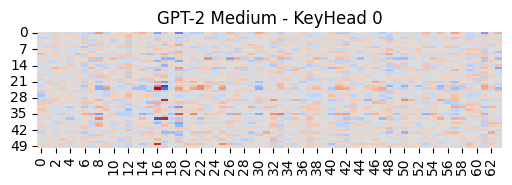

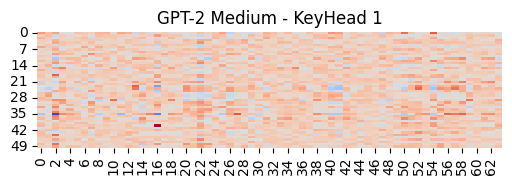

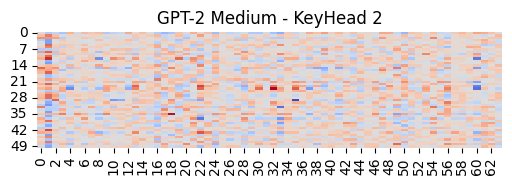

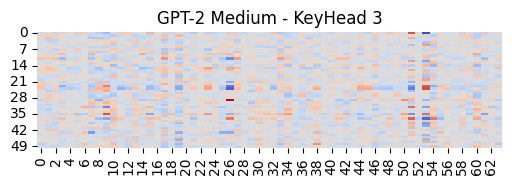

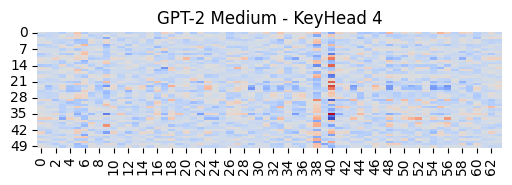

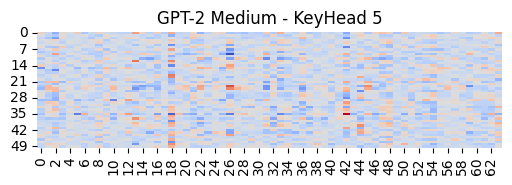


 GPT-2 Medium - Value Projections


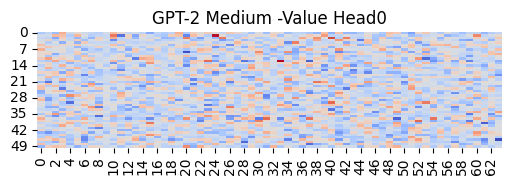

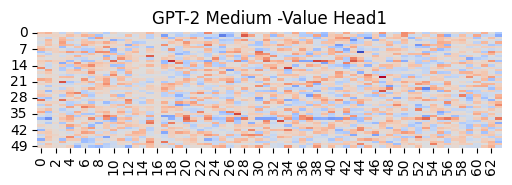

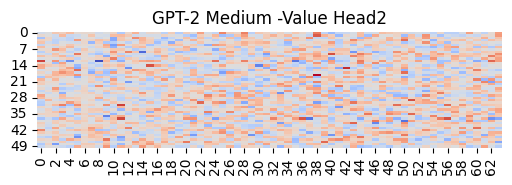

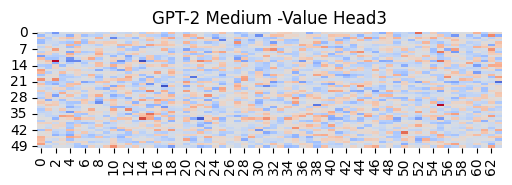

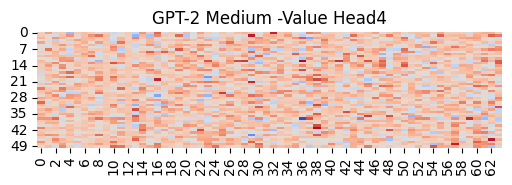

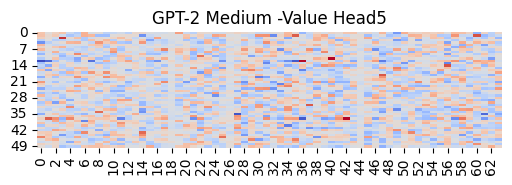


 Falcon-RW-1B - Key Pojections


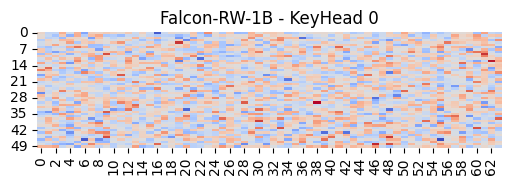

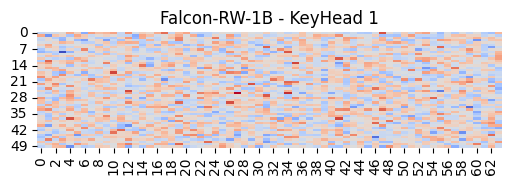

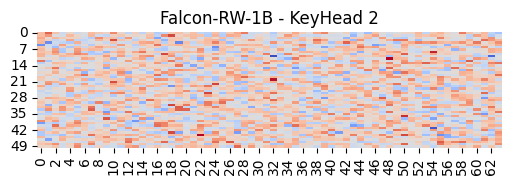

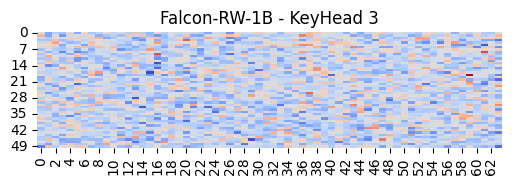

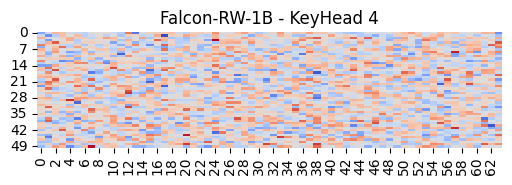

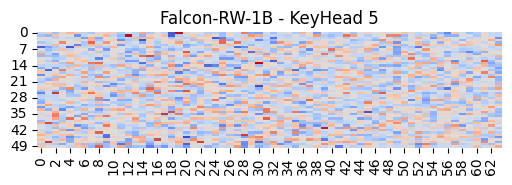


 Falcon-RW-1B - Value Projections


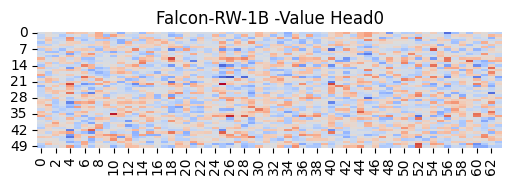

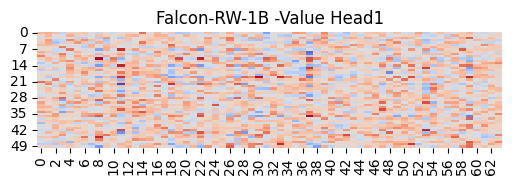

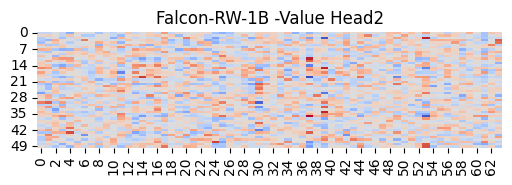

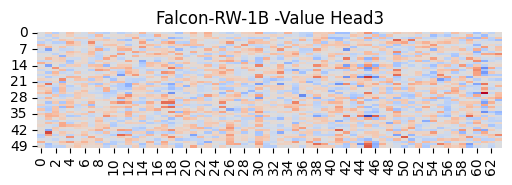

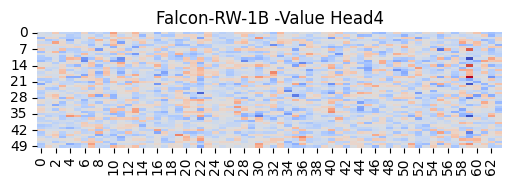

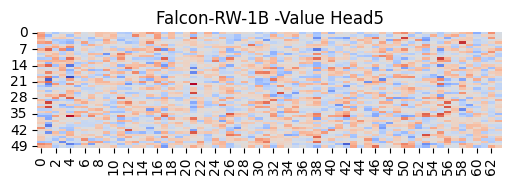

In [32]:
# Visualize for MHA (GPT-2 medium)
num_heads_mha = model_mha.config.n_head
visualize_kv_heads(W_k_mha, W_v_mha, num_heads_mha, "GPT-2 Medium")

# Visualize for MQA (Falcon-RW-1B)
num_heads_mqa = model_mqa.config.num_attention_heads
visualize_kv_heads(W_k_mqa, W_v_mqa, num_heads_mqa, "Falcon-RW-1B")